# Face Identification and Recognition

- **Face Identification** is a process in which we crop the all faces from image.

Face recognition problems commonly devide into two categories:

- **Face Recognition** - "who is this person?".

- **Face Verificatioin** -" is this the claimed person?".



Let's load the required packages. 


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from os import listdir
import os
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from keras.models import load_model
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot

%matplotlib inline

In [32]:


def extract_face(dir1,required_size=(160, 160)):
    X, y = list(), list()
    for file_labels in listdir(dir1):
        print('Celebrity:',file_labels)
        for img_loc in listdir(os.path.join(dir1,file_labels)):
            # load image from file
            filename=os.path.join(dir1,file_labels,img_loc)
            image = Image.open(filename)
            # convert to RGB, if needed
            image = image.convert('RGB')
            # convert to array
            pixels = asarray(image)
            # create the detector, using default weights
            detector = MTCNN()
            # detect faces in the image
            results = detector.detect_faces(pixels)
            # extract the bounding box from the first face
            x1, y1, width, height = results[0]['box']
            # bug fix
            x1, y1 = abs(x1), abs(y1)
            x2, y2 = x1 + width, y1 + height
            # extract the face
            face = pixels[y1:y2, x1:x2]
            # resize pixels to the model size
            image = Image.fromarray(face)
            image = image.resize(required_size)
            face_array = asarray(image)
            
            X.append(face_array)
            y.append(file_labels)

    
    return asarray(X), asarray(y)
            
        
        

trainX, trainy = extract_face('./data/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = extract_face('./data/val/')
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)


Celebrity: ben_afflek
Celebrity: madonna
Celebrity: jerry_seinfeld
Celebrity: mindy_kaling
Celebrity: elton_john
(93, 160, 160, 3) (93,)
Celebrity: ben_afflek
Celebrity: madonna
Celebrity: jerry_seinfeld
Celebrity: mindy_kaling
Celebrity: elton_john


In [ ]:
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

# load images and extract faces for all images in a directory
def load_faces(directory):
    faces = list()
    # enumerate files
    for filename in listdir(directory):
        # path
        path = directory + filename
        # get face
        face = extract_face(path)
        # store
        faces.append(face)
    return faces
    
    
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
    X, y = list(), list()
    # enumerate folders, on per class
    for subdir in listdir(directory):
        # path
        path = directory + subdir + '/'
        # skip any files that might be in the dir
        if not isdir(path):
            continue
        # load all faces in the subdirectory
        print(path)
        faces = load_faces(path)
        # create labels
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        print(labels)
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        # store
        X.extend(faces)
        y.extend(labels)
    return asarray(X), asarray(y)
 
# load train dataset
trainX, trainy = load_dataset('./data/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('./data/val/')
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

In [44]:
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

print(trainX[0].shape)


(160, 160, 3)


In [ ]:
model = load_model('./facenet_keras.h5')
# summarize input and output shape
print(model.inputs)
print(model.outputs)

## 1 - Encoding face images into a 128-dimensional vector 

### 1.1 - Using an FaceNet pretrained model  to compute encodings

The FaceNet model takes a lot of data and a long time to train. So following common practice in applied deep learning settings, let's just load weights that someone else has already trained.

The key things you need to know are:

- This network uses 160x160 dimensional RGB images as its input. Specifically, inputs a face image (or batch of $m$ face images) as a tensor of shape $(m, n_C, n_H, n_W) = (m, 3, 160, 160)$ 
- It outputs a matrix of shape $(m, 128)$ that encodes each input face image into a 128-dimensional vector

Run the cell below to create the model for face images.

In [33]:
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model
 
# get the face embedding for one face
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]
 
# load the face dataset
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
model = load_model('facenet_keras.h5')
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


W0826 15:21:37.667704 140339755812672 deprecation_wrapper.py:119] From /home/amit/anaconda3/envs/new_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0826 15:22:10.043050 140339755812672 deprecation.py:506] From /home/amit/anaconda3/envs/new_env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
/home/amit/anaconda3/envs/new_env/lib/python3.6/site-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loaded Model
(93, 128)
(25, 128)


In [34]:
# load faces
data = load('5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

In [36]:
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

In [37]:
print(trainX.shape,trainy.shape,testX.shape,testy.shape)


(93, 128) (93,) (25, 128) (25,)


In [38]:

# label encode targets
print(trainy)
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
print('After label Encoding:',trainy)

['ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'mindy_kaling'
 'mindy_kaling' 'mindy_kaling' 'mindy_kaling' 'mindy_kaling'
 'mindy_kaling' 'mindy_kaling' 'mindy_kaling' 'mindy_kaling'
 'mindy_kaling' 'mindy_kaling' 'mindy_kaling' 'mindy_kaling'
 'mindy_kaling' 'mindy_kaling' 'mindy_kaling' 'mindy_kaling'
 

In [39]:
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [40]:
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

In [41]:
print(random_face_name)

['madonna']


Predicted: madonna (87.794)
Expected: madonna


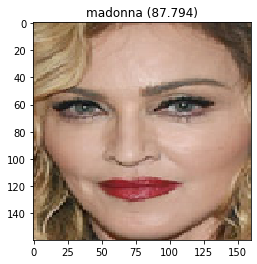

In [42]:



# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()